# G27
Dave Brunner

In [1]:
import torch
import torchvision
from matplotlib import pyplot as plt
from torch.nn import Sequential, Flatten, Linear, Module, Conv2d, MaxPool2d, CrossEntropyLoss, Tanh, ReLU
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Device is set to: {device}")

Device is set to: mps


In [3]:
data = DataLoader(
    datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor()))
X, _ = next(iter(data))
mean, std = X.mean(), X.std()

training_data = datasets.FashionMNIST(root="data", train=True, download=True,
                                      transform=Compose([ToTensor(), Normalize(mean, std)]))
test_data = datasets.FashionMNIST(root="data", train=False, download=True,
                                  transform=Compose([ToTensor(), Normalize(mean, std)]))
print(f'Mean: {mean}, Std: {std}')
print(f'Training data: {len(training_data)}')
print(f'Test data: {len(test_data)}')
print(f'Test data shape: {test_data.data.shape}')

Mean: 0.3813875913619995, Std: 0.3994404971599579
Training data: 60000
Test data: 10000
Test data shape: torch.Size([10000, 28, 28])


In [4]:
class CNN(Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.model = Sequential(
            Conv2d(1, 32, 3, 1),  # 32 * 26 * 26
            Tanh(),
            MaxPool2d(2, 2),  # 32 * 13 * 13
            Conv2d(32, 128, 3, 1),  # 128 * 11 * 11
            Tanh(),
            Conv2d(128, 128, 3, 1),  # 128 * 9 * 9
            Tanh(),
            Conv2d(128, 128, 3, 1),  # 128 * 7 * 7
            Tanh(),
            MaxPool2d(2, 2),  # 128 * 3 * 3
            Flatten(),
            Linear(128 * 3 * 3, 128),
            Tanh(),
            Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)

In [5]:
model = CNN()
print(model)

CNN(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): Tanh()
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (6): Tanh()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): Tanh()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1152, out_features=128, bias=True)
    (12): Tanh()
    (13): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [6]:
summary(model, (1, 28, 28))
model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              Tanh-2           [-1, 32, 26, 26]               0
         MaxPool2d-3           [-1, 32, 13, 13]               0
            Conv2d-4          [-1, 128, 11, 11]          36,992
              Tanh-5          [-1, 128, 11, 11]               0
            Conv2d-6            [-1, 128, 9, 9]         147,584
              Tanh-7            [-1, 128, 9, 9]               0
            Conv2d-8            [-1, 128, 7, 7]         147,584
              Tanh-9            [-1, 128, 7, 7]               0
        MaxPool2d-10            [-1, 128, 3, 3]               0
          Flatten-11                 [-1, 1152]               0
           Linear-12                  [-1, 128]         147,584
             Tanh-13                  [-1, 128]               0
           Linear-14                   

CNN(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): Tanh()
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (6): Tanh()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): Tanh()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1152, out_features=128, bias=True)
    (12): Tanh()
    (13): Linear(in_features=128, out_features=10, bias=True)
  )
)

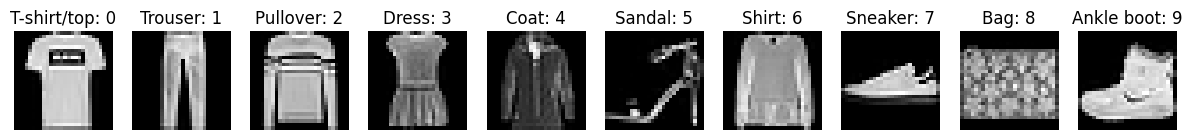

In [7]:
fig, axs = plt.subplots(1, 10, figsize=(15, 15))
for i in range(10):
    axs[i].imshow(training_data.data[training_data.targets == i][0], cmap='gray')
    axs[i].set_title(training_data.classes[i] + f': {i}')
    axs[i].axis('off')

In [8]:
def train_plot_model(model):
    n_epochs = 10
    n_batch = 1024
    loss_fn = CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    train_loader = DataLoader(training_data, batch_size=n_batch, shuffle=True)
    train_loader_all = DataLoader(training_data, batch_size=len(training_data), shuffle=True)
    test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=True)

    print('Moving data to device...')
    train_loader = [(data.to(device), target.to(device)) for data, target in train_loader]
    train_loader_all = [(data.to(device), target.to(device)) for data, target in train_loader_all]
    test_loader = [(data.to(device), target.to(device)) for data, target in test_loader]
    print(f'Data moved to device {device}')

    train_acc, val_acc = [], []
    train_loss, val_loss = [], []

    for epoch in range(n_epochs):
        # enumerate mini batches
        print(f'Epoch: {epoch + 1}')
        for batch_idx, (train_x, train_y) in enumerate(train_loader):
            optimizer.zero_grad()
            yhat = model(train_x)
            loss = loss_fn(yhat, train_y)
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            for train_x, train_y in train_loader_all:
                yhat = model(train_x)
                train_loss.append(loss_fn(yhat, train_y).item())
                train_acc.append(((yhat.argmax(1) == train_y).float().mean()).to('cpu'))
                print(f'Training   -> Loss: {train_loss[-1]:.3f}, Accuracy: {train_acc[-1]:.3f}')
            for test_x, test_y in test_loader:
                yhat = model(test_x)
                val_loss.append(loss_fn(yhat, test_y).item())
                val_acc.append(((yhat.argmax(1) == test_y).float().mean()).to('cpu'))
                print(f'Validation -> Loss: {val_loss[-1]:.3f}, Accuracy: {val_acc[-1]:.3f}')
        print('------------------------------------------------')
    plt.figure(1, figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
    return {
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc
    }

In [9]:
result_dict = {}

Regular model
Moving data to device...
Data moved to device mps
Epoch: 1
Training   -> Loss: 0.766, Accuracy: 0.715
Validation -> Loss: 0.784, Accuracy: 0.706
------------------------------------------------
Epoch: 2
Training   -> Loss: 0.567, Accuracy: 0.784
Validation -> Loss: 0.597, Accuracy: 0.766
------------------------------------------------
Epoch: 3
Training   -> Loss: 0.527, Accuracy: 0.800
Validation -> Loss: 0.552, Accuracy: 0.787
------------------------------------------------
Epoch: 4
Training   -> Loss: 0.486, Accuracy: 0.818
Validation -> Loss: 0.514, Accuracy: 0.811
------------------------------------------------
Epoch: 5
Training   -> Loss: 0.482, Accuracy: 0.824
Validation -> Loss: 0.514, Accuracy: 0.811
------------------------------------------------
Epoch: 6
Training   -> Loss: 0.422, Accuracy: 0.846
Validation -> Loss: 0.449, Accuracy: 0.838
------------------------------------------------
Epoch: 7
Training   -> Loss: 0.442, Accuracy: 0.840
Validation -> Loss: 

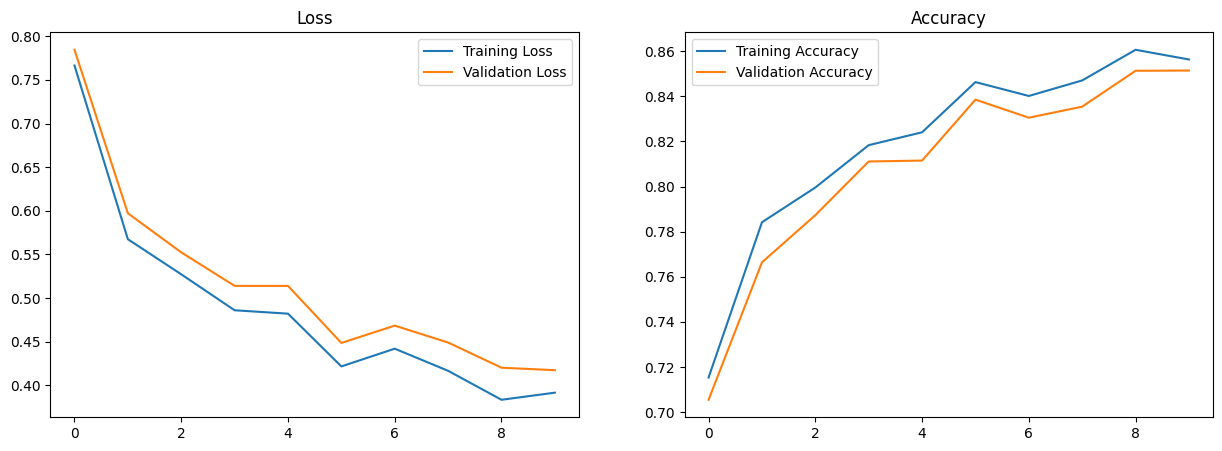

In [10]:
print('Regular model')
result_dict['regular'] = train_plot_model(CNN().to(device))

Model with zero initialization
Moving data to device...
Data moved to device mps
Epoch: 1
Training   -> Loss: 2.303, Accuracy: 0.100
Validation -> Loss: 2.303, Accuracy: 0.100
------------------------------------------------
Epoch: 2
Training   -> Loss: 2.303, Accuracy: 0.100
Validation -> Loss: 2.303, Accuracy: 0.100
------------------------------------------------
Epoch: 3
Training   -> Loss: 2.303, Accuracy: 0.100
Validation -> Loss: 2.303, Accuracy: 0.100
------------------------------------------------
Epoch: 4
Training   -> Loss: 2.303, Accuracy: 0.100
Validation -> Loss: 2.303, Accuracy: 0.100
------------------------------------------------
Epoch: 5
Training   -> Loss: 2.303, Accuracy: 0.100
Validation -> Loss: 2.303, Accuracy: 0.100
------------------------------------------------
Epoch: 6
Training   -> Loss: 2.303, Accuracy: 0.100
Validation -> Loss: 2.303, Accuracy: 0.100
------------------------------------------------
Epoch: 7
Training   -> Loss: 2.303, Accuracy: 0.100
Val

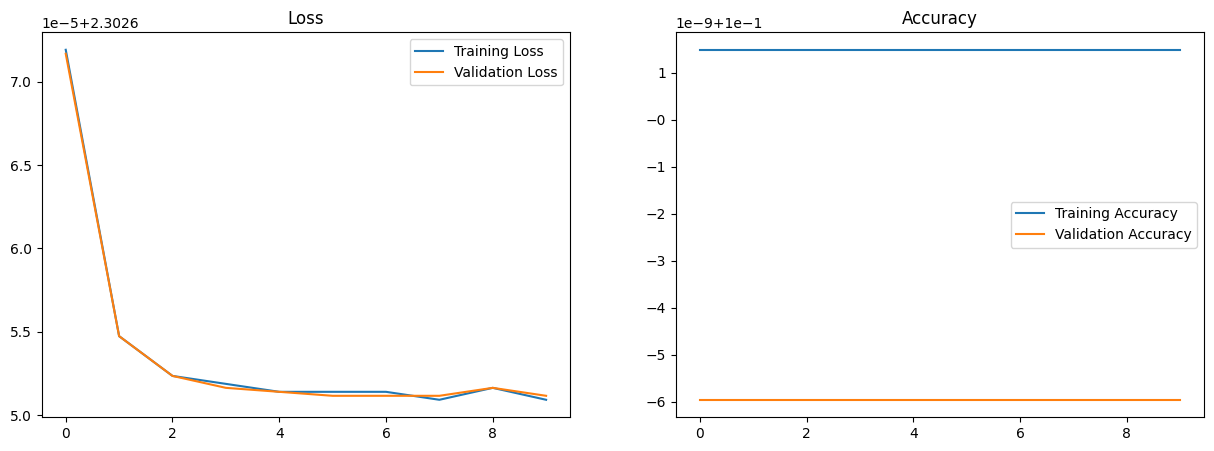

In [11]:
class CnnZeroInitialization(Module):
    def __init__(self):
        super(CnnZeroInitialization, self).__init__()
        self.model = Sequential(
            Conv2d(1, 32, 3, 1),  # 32 * 26 * 26
            Tanh(),
            MaxPool2d(2, 2),  # 32 * 13 * 13
            Conv2d(32, 128, 3, 1),  # 128 * 11 * 11
            Tanh(),
            Conv2d(128, 128, 3, 1),  # 128 * 9 * 9
            Tanh(),
            Conv2d(128, 128, 3, 1),  # 128 * 7 * 7
            Tanh(),
            MaxPool2d(2, 2),  # 128 * 3 * 3
            Flatten(),
            Linear(128 * 3 * 3, 128),
            Tanh(),
            Linear(128, 10)
        )
        self.model.apply(self.init_weights)

    def forward(self, x):
        return self.model(x)

    @staticmethod
    def init_weights(m):
        if type(m) == Conv2d or type(m) == Linear:
            torch.nn.init.zeros_(m.weight)
            m.bias.data.fill_(0)
            
print('Model with zero initialization')
result_dict['all_zero'] = train_plot_model(CnnZeroInitialization().to(device))

Model with uniform weights and zero bias
Moving data to device...
Data moved to device mps
Epoch: 1
Training   -> Loss: 0.816, Accuracy: 0.703
Validation -> Loss: 0.841, Accuracy: 0.698
------------------------------------------------
Epoch: 2
Training   -> Loss: 0.741, Accuracy: 0.725
Validation -> Loss: 0.779, Accuracy: 0.715
------------------------------------------------
Epoch: 3
Training   -> Loss: 0.718, Accuracy: 0.727
Validation -> Loss: 0.747, Accuracy: 0.716
------------------------------------------------
Epoch: 4
Training   -> Loss: 0.668, Accuracy: 0.747
Validation -> Loss: 0.697, Accuracy: 0.745
------------------------------------------------
Epoch: 5
Training   -> Loss: 0.669, Accuracy: 0.741
Validation -> Loss: 0.696, Accuracy: 0.733
------------------------------------------------
Epoch: 6
Training   -> Loss: 0.632, Accuracy: 0.761
Validation -> Loss: 0.660, Accuracy: 0.752
------------------------------------------------
Epoch: 7
Training   -> Loss: 0.638, Accuracy:

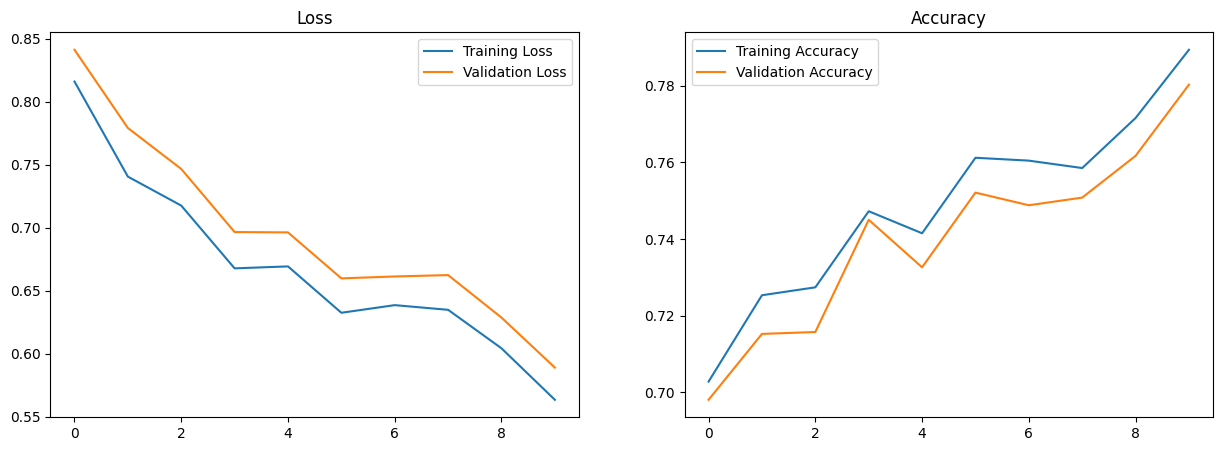

In [12]:
class CnnUniformWeightsZeroBias(Module):
    def __init__(self):
        super(CnnUniformWeightsZeroBias, self).__init__()
        self.model = Sequential(
            Conv2d(1, 32, 3, 1),  # 32 * 26 * 26
            Tanh(),
            MaxPool2d(2, 2),  # 32 * 13 * 13
            Conv2d(32, 128, 3, 1),  # 128 * 11 * 11
            Tanh(),
            Conv2d(128, 128, 3, 1),  # 128 * 9 * 9
            Tanh(),
            Conv2d(128, 128, 3, 1),  # 128 * 7 * 7
            Tanh(),
            MaxPool2d(2, 2),  # 128 * 3 * 3
            Flatten(),
            Linear(128 * 3 * 3, 128),
            Tanh(),
            Linear(128, 10)
        )
        self.model.apply(self.init_weights)

    def forward(self, x):
        return self.model(x)

    @staticmethod
    def init_weights(m):
        if type(m) == Conv2d or type(m) == Linear:
            torch.nn.init.uniform_(m.weight, -0.5, 0.5)
            m.bias.data.fill_(0)

print('Model with uniform weights and zero bias')
result_dict['uniform_weights_zero_bias'] = train_plot_model(CnnUniformWeightsZeroBias().to(device))

Model with Xavier Glorot initialization and zero bias with Tanh activation function
Moving data to device...
Data moved to device mps
Epoch: 1
Training   -> Loss: 0.703, Accuracy: 0.742
Validation -> Loss: 0.718, Accuracy: 0.737
------------------------------------------------
Epoch: 2
Training   -> Loss: 0.675, Accuracy: 0.742
Validation -> Loss: 0.695, Accuracy: 0.735
------------------------------------------------
Epoch: 3
Training   -> Loss: 0.575, Accuracy: 0.785
Validation -> Loss: 0.597, Accuracy: 0.778
------------------------------------------------
Epoch: 4
Training   -> Loss: 0.539, Accuracy: 0.802
Validation -> Loss: 0.561, Accuracy: 0.793
------------------------------------------------
Epoch: 5
Training   -> Loss: 0.503, Accuracy: 0.812
Validation -> Loss: 0.531, Accuracy: 0.800
------------------------------------------------
Epoch: 6
Training   -> Loss: 0.482, Accuracy: 0.822
Validation -> Loss: 0.511, Accuracy: 0.812
------------------------------------------------
Ep

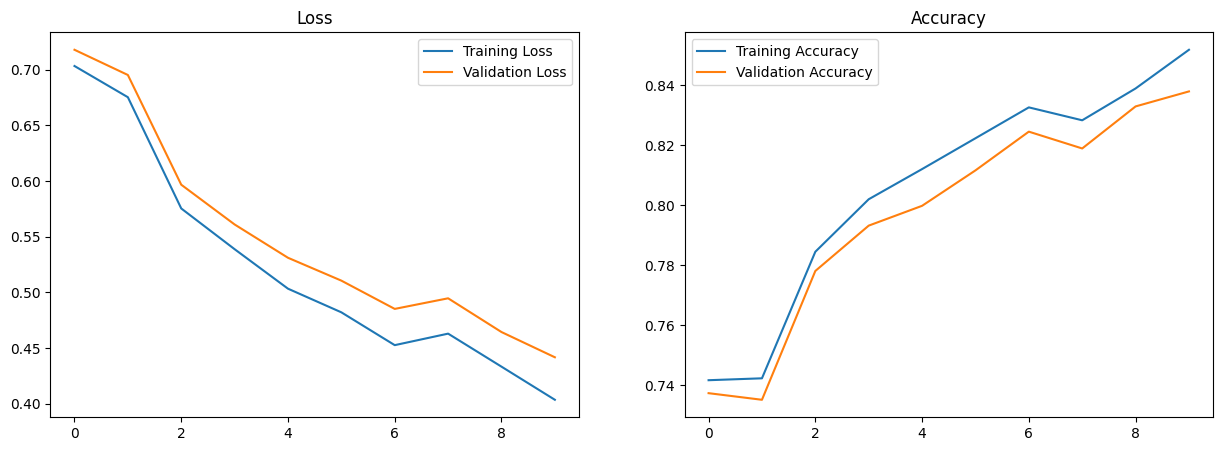

In [13]:
class CnnXavierGlorot(Module):
    def __init__(self):
        super(CnnXavierGlorot, self).__init__()
        self.model = Sequential(
            Conv2d(1, 32, 3, 1),  # 32 * 26 * 26
            Tanh(),
            MaxPool2d(2, 2),  # 32 * 13 * 13
            Conv2d(32, 128, 3, 1),  # 128 * 11 * 11
            Tanh(),
            Conv2d(128, 128, 3, 1),  # 128 * 9 * 9
            Tanh(),
            Conv2d(128, 128, 3, 1),  # 128 * 7 * 7
            Tanh(),
            MaxPool2d(2, 2),  # 128 * 3 * 3
            Flatten(),
            Linear(128 * 3 * 3, 128),
            Tanh(),
            Linear(128, 10)
        )
        self.model.apply(self.init_weights)

    def forward(self, x):
        return self.model(x)

    @staticmethod
    def init_weights(m):
        if type(m) == Conv2d or type(m) == Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0)


print('Model with Xavier Glorot initialization and zero bias with Tanh activation function')
result_dict['xavier_weights_zero_bias_tanh'] = train_plot_model(CnnXavierGlorot().to(device))

Model with Kaiming He initialization and zero bias with ReLU activation function
Moving data to device...
Data moved to device mps
Epoch: 1
Training   -> Loss: 0.558, Accuracy: 0.787
Validation -> Loss: 0.590, Accuracy: 0.780
------------------------------------------------
Epoch: 2
Training   -> Loss: 0.396, Accuracy: 0.854
Validation -> Loss: 0.438, Accuracy: 0.841
------------------------------------------------
Epoch: 3
Training   -> Loss: 0.329, Accuracy: 0.879
Validation -> Loss: 0.375, Accuracy: 0.866
------------------------------------------------
Epoch: 4
Training   -> Loss: 0.299, Accuracy: 0.890
Validation -> Loss: 0.351, Accuracy: 0.874
------------------------------------------------
Epoch: 5
Training   -> Loss: 0.273, Accuracy: 0.900
Validation -> Loss: 0.332, Accuracy: 0.879
------------------------------------------------
Epoch: 6
Training   -> Loss: 0.262, Accuracy: 0.904
Validation -> Loss: 0.332, Accuracy: 0.880
------------------------------------------------
Epoch

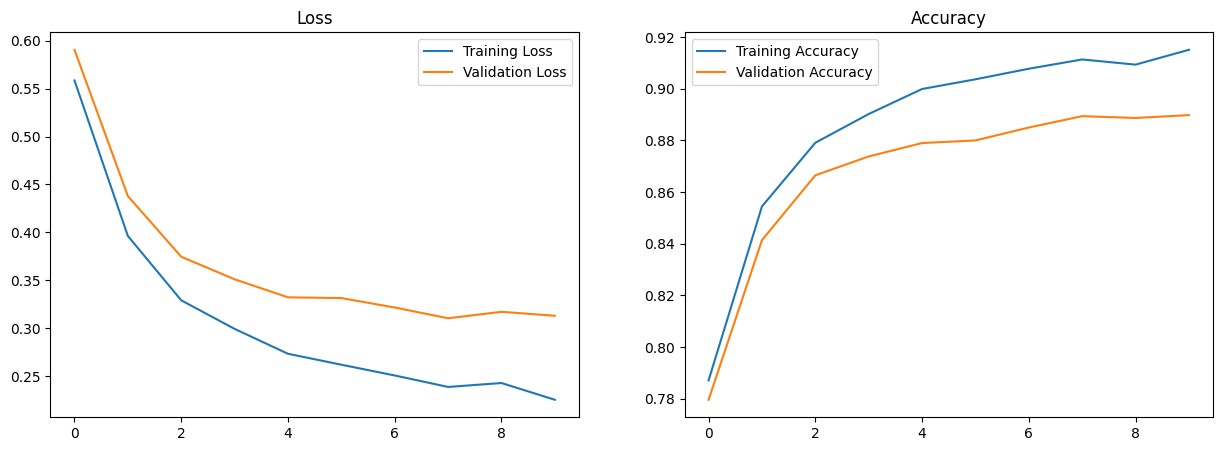

In [14]:
class CnnKaimingHe(Module):
    def __init__(self):
        super(CnnKaimingHe, self).__init__()
        self.model = Sequential(
            Conv2d(1, 32, 3, 1),  # 32 * 26 * 26
            ReLU(),
            MaxPool2d(2, 2),  # 32 * 13 * 13
            Conv2d(32, 128, 3, 1),  # 128 * 11 * 11
            ReLU(),
            Conv2d(128, 128, 3, 1),  # 128 * 9 * 9
            ReLU(),
            Conv2d(128, 128, 3, 1),  # 128 * 7 * 7
            ReLU(),
            MaxPool2d(2, 2),  # 128 * 3 * 3
            Flatten(),
            Linear(128 * 3 * 3, 128),
            ReLU(),
            Linear(128, 10)
        )
        self.model.apply(self.init_weights)

    def forward(self, x):
        return self.model(x)

    @staticmethod
    def init_weights(m):
        if type(m) == Conv2d or type(m) == Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0)


print('Model with Kaiming He initialization and zero bias with ReLU activation function')
result_dict['kaiming_weights_zero_bias_ReLU'] = train_plot_model(CnnKaimingHe().to(device))

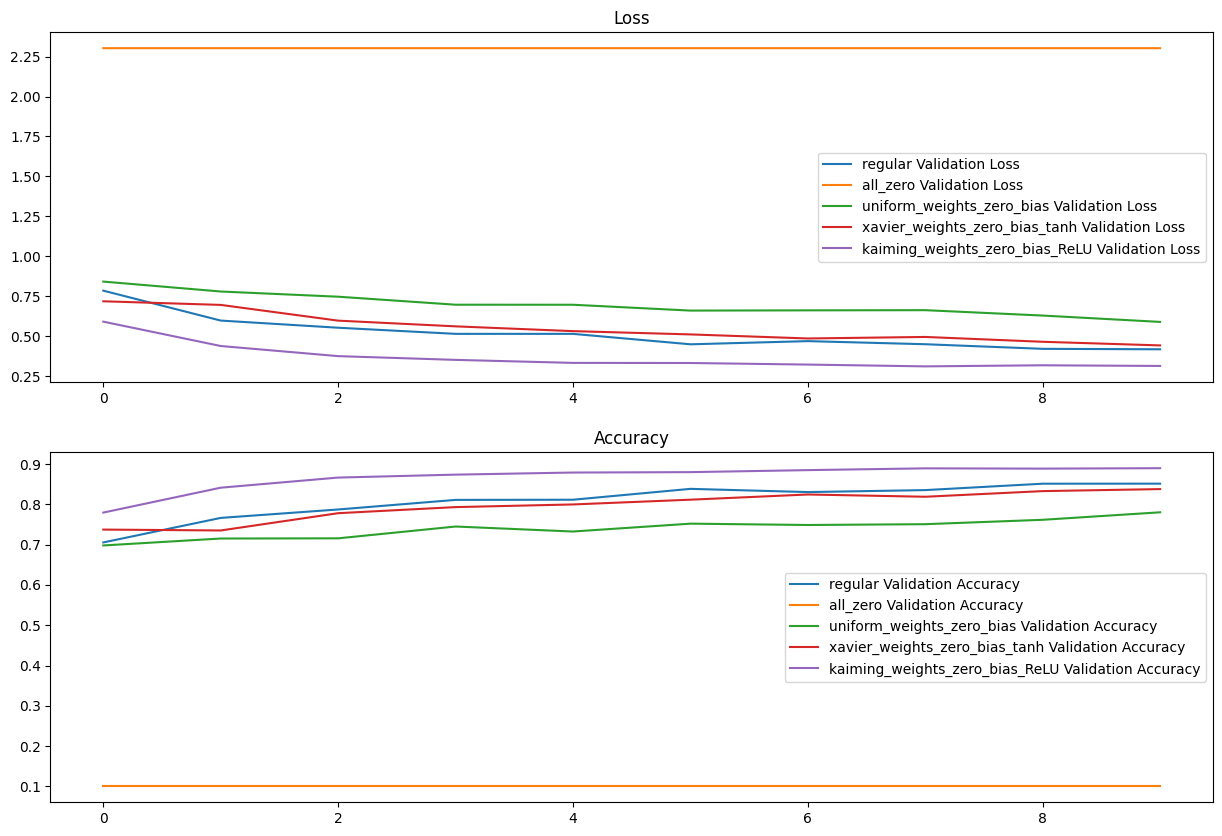

In [15]:
plt.figure(1, figsize=(15, 10))
plt.subplot(2, 1, 1)
for key, value in result_dict.items():
    # plt.plot(value['train_loss'], label=f'{key} Training Loss')
    plt.plot(value['val_loss'], label=f'{key} Validation Loss')
plt.title('Loss')
plt.legend()
plt.subplot(2, 1, 2)
for key, value in result_dict.items():
    # plt.plot(value['train_acc'], label=f'{key} Training Accuracy')
    plt.plot(value['val_acc'], label=f'{key} Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

The plots show that the initialization of the weights with "kaiming weights, zero bias, ReLU" delivers the best performance and that sophisticated initialization strategies lead to faster learning (in earlier epochs) and higher accuracy and lower loss rates.
Interesting to see that the "all zero" initialization strategy is producing a constant accuracy of 10%. This is due to the fact that during training the weights and biases of all neurons are update by the exact same amount, so it will always predict the same output and because there are 10 different labels that explains why the accuracy is 10%.